In [49]:
import numpy as np
from numpy.random import uniform
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import interp1d
import sympy as smp
from scipy.stats import rv_continuous
plt.style.use(['science', 'notebook'])
from functions import *
import functions as f

# Problem 1

## Part A

Create radiation simulation object for photons emitted isotropically from point source.

In [50]:
N = 1000000
E0 = 50
E = E0*np.ones(N)
X = np.zeros((3,N))
Phi0 = 2*np.pi*uniform(size=N)
Theta0 = np.arccos(1-2*uniform(size=N))
Ang = np.array([Phi0, Theta0])
Ebins = 10.0**(np.linspace(-3,np.log10(E0), 100))
int_types = np.arange(4)
r = RadSim(E, X, Ang, Ebins, int_types)

Run simultion

In [51]:
while True:
    if r.iterate():
        break

Open up relative probability of different interactions at different energies

* From simulation
* Theoretically from attenuation coefficients

In [52]:
'''From simulation'''
int_total_per_energy = r.IntHist_p.sum(axis=0)
a1, a2, a3, a4 = r.IntHist_p / int_total_per_energy 

'''Attenuation coefficient data'''
df = pd.read_csv('water_data.txt', sep=' ', dtype=np.float32)
energy_d = df['Energy(MeV)'].values
coherent_d = df['Coherent(cm^2g^-1)'].values
compton_d = df['Compton(cm^2g^-1)'].values
photo_d = df['Photoelectric(cm^2g^-1)'].values
pairtrip_d = df['Pair+Triplet(cm^2g^-1)'].values
Etrans_d = df['Energy-Transfer(cm^2g^-1)'].values
Eabs_d = df['Energy-Absorption(cm^2g^-1)'].values
brem_d = df['1-g'].values
mu_d = coherent_d + compton_d+photo_d + pairtrip_d

/Users/lukepolson/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


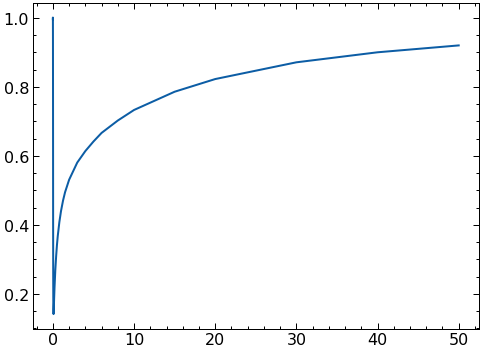

In [154]:
plt.plot(energy_d, Etrans_d/mu_d)

Plot

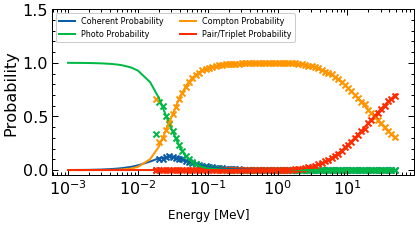

In [53]:
fig, ax = plt.subplots(1, 1, figsize=(6,3))
ax.plot(energy_d, coherent_d/mu_d, label=r'Coherent Probability')
ax.plot(energy_d, photo_d/mu_d, label=r'Photo Probability')
ax.plot(energy_d, compton_d/mu_d, label=r'Compton Probability')
ax.plot(energy_d, pairtrip_d/mu_d, label=r'Pair/Triplet Probability')
ax.semilogx()
ax.legend(fontsize=8, ncol=2, facecolor='white', framealpha=1, frameon=True, loc='upper left')
ax.set_ylim(top=1.5)
ax.set_ylabel('Probability')
fig.suptitle('Energy [MeV]', y=0)
fig.tight_layout()
plt.scatter(Ebins[0:-1] + np.diff(Ebins)/2, a1, marker='x')
plt.scatter(Ebins[0:-1] + np.diff(Ebins)/2, a2, marker='x')
plt.scatter(Ebins[0:-1] + np.diff(Ebins)/2, a3, marker='x')
plt.scatter(Ebins[0:-1] + np.diff(Ebins)/2, a4, marker='x')
plt.savefig('images/q1.png', dpi=200)
plt.show()

## Part B

Get analytical formula

In [54]:
E, alpha, T, theta = smp.symbols(r'E \alpha T \theta', real=True, positive=True)
T_expr = E*alpha*(1-smp.cos(theta))/(1+alpha*(1-smp.cos(theta)))
theta_expr = smp.solve(T-T_expr, theta)[1]
dsdo_expr = smp.Rational(1,2)*(1+smp.cos(theta)**2)/(1+alpha*(1-smp.cos(theta)))**2 * \
            ( 1 + alpha**2 * (1-smp.cos(theta))**2 / ((1+smp.cos(theta)**2)*(1+alpha*(1-smp.cos(theta)))))
dsdT = 2*smp.pi*smp.sin(theta) * dsdo_expr / smp.diff(T_expr, theta)
dsdT = dsdT.subs(theta, theta_expr).simplify()
Tmin = 0 
Tmax = 2*E*alpha/(1+2*alpha)
sigma_check = smp.integrate(dsdT, (T, Tmin, Tmax)).expand().simplify().simplify()
pdf = dsdT / sigma_check
avgT = smp.integrate(pdf*(T/E), (T, Tmin, Tmax)).simplify().simplify()
avgT_f = smp.lambdify(alpha, avgT)

In [55]:
avgT

(-20*\alpha**5 + 102*\alpha**4 + 186*\alpha**3 + 102*\alpha**2 + 18*\alpha + (24*\alpha**5 - 12*\alpha**4 - 126*\alpha**3 - 141*\alpha**2 - 60*\alpha - 9)*log(2*\alpha + 1))/(3*(4*\alpha**5 + 38*\alpha**4 + 50*\alpha**3 + 24*\alpha**2 + 4*\alpha + (8*\alpha**5 - 4*\alpha**4 - 34*\alpha**3 - 35*\alpha**2 - 14*\alpha - 2)*log(2*\alpha + 1)))

In [56]:
print(smp.latex(avgT))

\frac{- 20 \alpha^{5} + 102 \alpha^{4} + 186 \alpha^{3} + 102 \alpha^{2} + 18 \alpha + \left(24 \alpha^{5} - 12 \alpha^{4} - 126 \alpha^{3} - 141 \alpha^{2} - 60 \alpha - 9\right) \log{\left(2 \alpha + 1 \right)}}{3 \left(4 \alpha^{5} + 38 \alpha^{4} + 50 \alpha^{3} + 24 \alpha^{2} + 4 \alpha + \left(8 \alpha^{5} - 4 \alpha^{4} - 34 \alpha^{3} - 35 \alpha^{2} - 14 \alpha - 2\right) \log{\left(2 \alpha + 1 \right)}\right)}


In [72]:
energy_arr = np.linspace(0.01, 50, 10000) 
avgT_arr = avgT_f(energy_arr/0.511)

Get compton angles from simulation

In [73]:
ratios, bins = np.histogram(r.comptonenergies, Ebins, weights=r.comptonratios)
total, bins = np.histogram(r.comptonenergies, Ebins)
T = ratios/total
Ep = bins[:-1] + np.diff(bins)/2

/Users/lukepolson/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


Plot

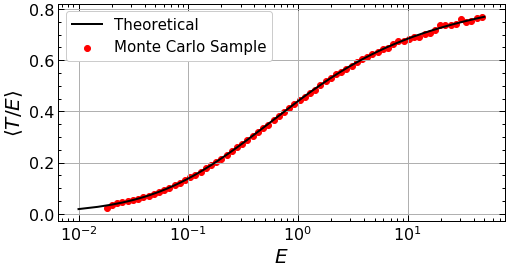

In [74]:
plt.figure(figsize=(8,4))
plt.scatter(Ep, T, color='r', label='Monte Carlo Sample')
plt.plot(energy_arr, avgT_arr, color='k', label='Theoretical')
plt.xlabel('$E$', fontsize=20)
plt.ylabel(r'$\left<T/E\right>$', fontsize=20)
plt.grid()
plt.legend(fontsize=15, facecolor='white', framealpha=1, frameon=True, loc='upper left')
plt.semilogx()
plt.savefig('images/q2.png', dpi=200)
plt.show()

## Part C

In [60]:
avg_inters = []
for E0 in energy_d:
    N = 5000
    E = E0*np.ones(N)
    X = np.zeros((3,N))
    Phi0 = 2*np.pi*uniform(size=N)
    Theta0 = np.arccos(1-2*uniform(size=N))
    Ang = np.array([Phi0, Theta0])
    Ebins = 10.0**(np.linspace(-3,np.log10(E0), 100))
    int_types = np.arange(4)
    ri = RadSim(E, X, Ang, Ebins, int_types)
    while True:
        if ri.iterate():
            break
    avg_inters.append(len(ri.E_e)/N)
avg_inters = np.array(avg_inters)

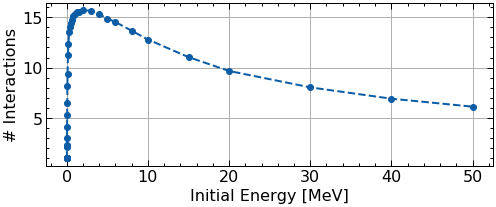

In [76]:
plt.figure(figsize=(8,3))
plt.plot(energy_d, avg_inters, 'o--')
plt.xlabel('Initial Energy [MeV]')
plt.ylabel('# Interactions')
plt.grid()
plt.savefig('images/q3.png', dpi=200)
plt.show()

## Part D

Note: there should be no preferred direction

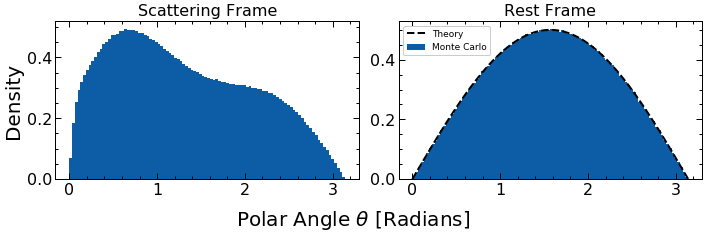

In [62]:
fig, ax = plt.subplots(figsize=(10,3))
plt.subplot(121)
plt.hist(r.comptonthetas, bins=100, density=True)
plt.title('Scattering Frame')
plt.ylabel('Density', fontsize=20)
plt.subplot(122)
plt.hist(r.comptonthetas_rest, bins=100, density=True, label='Monte Carlo')
plt.title('Rest Frame')
plt.plot(np.linspace(0,np.pi,100), np.sin(np.linspace(0,np.pi,100))/2, 'k--', label='Theory')
plt.legend(fontsize=9, facecolor='white', framealpha=1, frameon=True, loc='upper left')
fig.tight_layout()
fig.suptitle(r'Polar Angle $\theta$ [Radians]',x=0.5,y=0, ha='center', fontsize=20)
plt.savefig('images/q4.png', dpi=200)
plt.show()

# Problem 2

In [33]:
# Run this or the cell below
N = 1000000
E = get_6MV_spectrum(N)
np.random.shuffle(E)
phi = 2*np.pi*np.random.uniform(size=N)
x = 10 * (np.random.uniform(size=N) - 0.5)
y = 10 * (np.random.uniform(size=N) - 0.5)
z=np.zeros(N)
X = np.array([x, y, z])
theta = np.zeros(N)
Ang = np.array([phi, theta])
Ebins = 10.0**(np.linspace(-3,1,100))
int_types = np.arange(4)
r = RadSim(E, X, Ang, Ebins, int_types, XYZ_lim=[15.,15.,0.,50.])

In [77]:
# Run this or the cell below
N = 5000000
E = get_6MV_spectrum(N)
R = np.sqrt(2) * np.sqrt(np.log(6/E))
phi = 2*np.pi*np.random.uniform(size=N)
x = R*np.cos(phi); y = R*np.sin(phi); z=np.zeros(N)
X = np.array([x, y, z])
theta = np.arctan(R/100)
Ang = np.array([phi, theta])
Ebins = 10.0**(np.linspace(-3,1,100))
int_types = np.arange(4)
r = RadSim(E, X, Ang, Ebins, int_types, XYZ_lim=[15.,15.,0.,50.])

In [78]:
while True:
    if r.iterate():
        break

In [79]:
binsx = np.arange(-15.25,15.75,0.5)
binsy = np.arange(-15.25,15.75,0.5)
binsz = np.arange(0,50.5,0.5)
kerma_hist, dose_hist = r.compute_volume_hists(binsx, binsy, binsz, dEdx=2)

In [80]:
x = binsx[1:] - np.diff(binsx)[0]/2
y = binsy[1:] - np.diff(binsy)[0]/2
xv, yv = np.meshgrid(x,y)

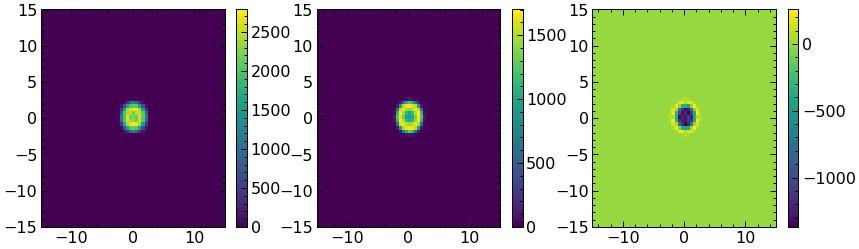

In [129]:
slc = 0
plt.figure(figsize=(14,4))
plt.subplot(131)
plt.pcolormesh(xv, yv, kerma_hist[:,:,slc])
plt.colorbar()
plt.subplot(132)
plt.pcolormesh(xv, yv, dose_hist[:,:,slc])
plt.colorbar()
plt.subplot(133)
plt.pcolormesh(xv, yv, dose_hist[:,:,slc] - kerma_hist[:,:,slc])
plt.colorbar()

In [90]:
z = binsz[1:] -np.diff(binsz)/2
M_to_J = 1.60218e-13
l = 29
u = 32
kerma_center = np.mean(kerma_hist[l:u,l:u,:], axis=(0,1)) * M_to_J
dose_center = np.mean(dose_hist[l:u,l:u,:], axis=(0,1)) *M_to_J
kerma_all = np.sum(kerma_hist, axis=(0,1)) *M_to_J
dose_all = np.sum(dose_hist, axis=(0,1)) *M_to_J

oc = xv**2 + yv**2 >= 1.5
oc_bool = np.tile(oc, (kerma_hist.shape[-1],1,1)).astype(int)
kerma_outer = np.sum(kerma_hist*oc_bool.T, axis=(0,1)) *M_to_J
dose_outer = np.sum(dose_hist*oc_bool.T, axis=(0,1)) *M_to_J

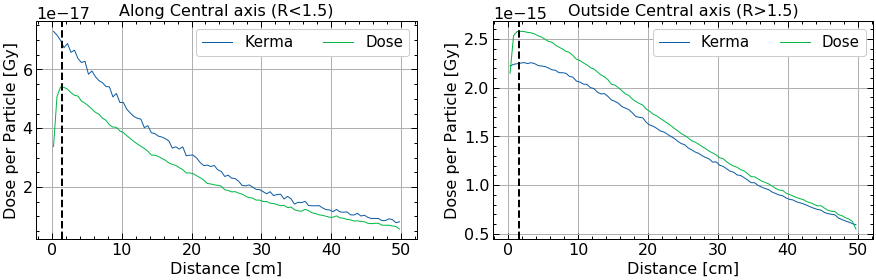

In [91]:
plt.figure(figsize=(15,4))
plt.subplot(121)
plt.title('Along Central axis (R<1.5)')
plt.plot(z, kerma_center/N, label='Kerma', lw=1)
plt.plot(z, dose_center/N, label='Dose', lw=1)
plt.axvline(1.5, color='k', ls='--')
plt.grid()
plt.legend(ncol=2, fontsize=15, facecolor='white', framealpha=1, frameon=True, loc='upper right')
plt.xlabel('Distance [cm]')
plt.ylabel('Dose per Particle [Gy]')
plt.subplot(122)
plt.title('Outside Central axis (R>1.5)')
plt.plot(z, kerma_outer/N, label='Kerma', lw=1)
plt.plot(z, dose_outer/N, label='Dose', lw=1)
plt.axvline(1.5, color='k', ls='--')
plt.grid()
plt.legend(ncol=2, fontsize=15, facecolor='white', framealpha=1, frameon=True, loc='upper right')
plt.xlabel('Distance [cm]')
plt.ylabel('Dose per Particle [Gy]')
plt.savefig('dosekerma.png', dpi=200)
plt.show()

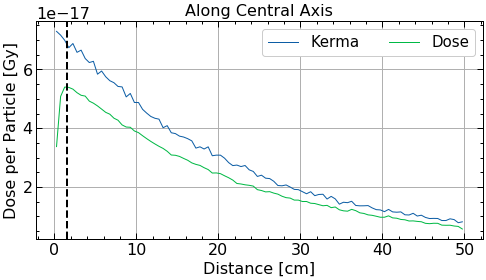

In [93]:
plt.figure(figsize=(8,4))
plt.subplot(111)
plt.title('Along Central Axis')
plt.plot(z, kerma_center/N, label='Kerma', lw=1)
plt.plot(z, dose_center/N, label='Dose', lw=1)
plt.axvline(1.5, color='k', ls='--')
plt.grid()
plt.legend(ncol=2, fontsize=15, facecolor='white', framealpha=1, frameon=True, loc='upper right')
plt.xlabel('Distance [cm]')
plt.ylabel('Dose per Particle [Gy]')
plt.savefig('dosekerma.png', dpi=200)
plt.show()

In [123]:
d = x
cross_x_1 = (dose_hist[:,30,z==1.25] + dose_hist[:,30,z==1.75])/2  * M_to_J / N 
cross_x_5 = (dose_hist[:,30,z==4.75] + dose_hist[:,30,z==5.25])/2* M_to_J / N 
cross_x_10 = (dose_hist[:,30,z==9.75] + dose_hist[:,30,z==10.25])/2 * M_to_J / N 
cross_x_20 = (dose_hist[:,30,z==19.75] + dose_hist[:,30,z==20.25])/2 * M_to_J / N 
cross_y_1 = (dose_hist[30,:,z==1.25] + dose_hist[30,:,z==1.75])/2 * M_to_J / N 
cross_y_5 = (dose_hist[30,:,z==4.75] + dose_hist[30,:,z==5.25])/2 * M_to_J / N 
cross_y_10 = (dose_hist[30,:,z==9.75] + dose_hist[30,:,z==10.25])/2 * M_to_J / N 
cross_y_20 = (dose_hist[30,:,z==19.75] + dose_hist[30,:,z==20.25])/2 * M_to_J / N 

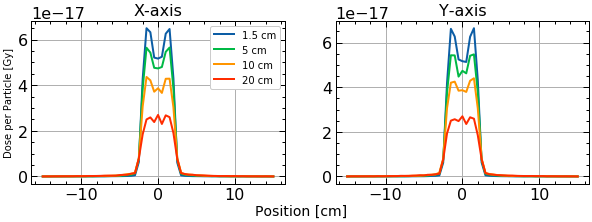

In [148]:
fig = plt.figure(figsize=(10,3))
plt.subplot(121)
plt.plot(d,cross_x_1.ravel(), label='1.5 cm')
plt.plot(d,cross_x_5.ravel(), label='5 cm')
plt.plot(d,cross_x_10.ravel(), label='10 cm')
plt.plot(d,cross_x_20.ravel(), label='20 cm')
plt.ylabel('Dose per Particle [Gy]', fontsize=10)
plt.title('X-axis')
plt.grid()
plt.legend(fontsize=10, facecolor='white', framealpha=1, frameon=True, loc='upper right')
plt.subplot(122)
plt.plot(d,cross_y_1.ravel(), label='1.5 cm')
plt.plot(d,cross_y_5.ravel(), label='5 cm')
plt.plot(d,cross_y_10.ravel(), label='10 cm')
plt.plot(d,cross_y_20.ravel(), label='20 cm')
plt.title('Y-axis')
plt.grid()
fig.suptitle(r'Position [cm]',x=0.5,y=0.03, ha='center', fontsize=14)
plt.show()

## Kerma Plot

$$E_{trans}(z) = N_{\gamma}(z) \left<E(z)\right> \frac{\mu_{tr}}{\mu} $$

* $N_{\gamma}(z)$ obtained from monte carlo
* $\left<E(z)\right> = $

$ z \propto 1/\mu(E)$

In [90]:
value, bins = np.histogram(r.comptonenergies, Ebins, weights=r.comptonthetaes)
total, bins = np.histogram(r.comptonenergies, Ebins)
ce = value/total
Ep = bins[:-1] + np.diff(bins)/2

/Users/lukepolson/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


(array([32622., 68356., 70683., 59895., 49474., 43311., 39989., 34592.,
        23985.,  8915.]),
 array([1.36677511e-03, 3.15067378e-01, 6.28767980e-01, 9.42468582e-01,
        1.25616918e+00, 1.56986979e+00, 1.88357039e+00, 2.19727099e+00,
        2.51097159e+00, 2.82467220e+00, 3.13837280e+00]),
 <a list of 10 Patch objects>)

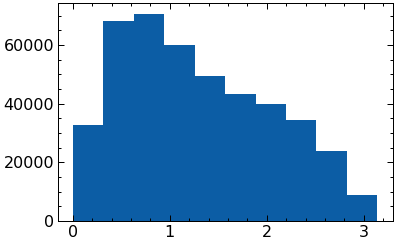

In [12]:
plt.hist(r.comptonthetas)

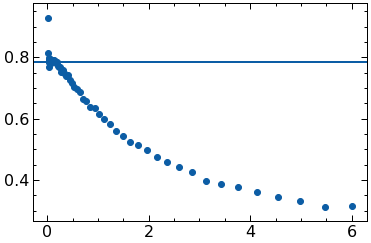

In [13]:
plt.scatter(Ep, ce)
plt.axhline(np.pi/4)

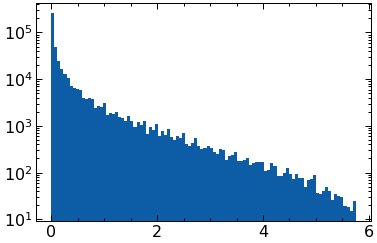

In [54]:
plt.hist(r.E_e, bins=100)
plt.semilogy()
plt.show()

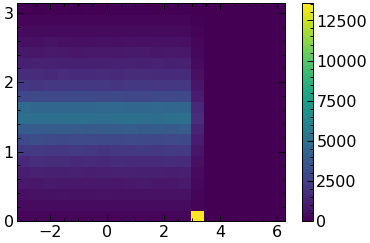

In [47]:
plt.hist2d(r.Ang_e[0], r.Ang_e[1], bins=20)
plt.colorbar()
plt.show()

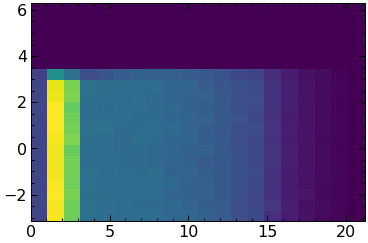

In [48]:
plt.hist2d(np.sqrt(r.X_e[0]**2 + r.X_e[1]**2), r.Ang_e[0], bins=20)
plt.show()

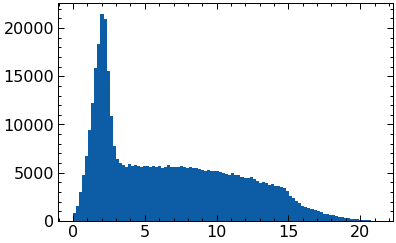

In [49]:
plt.hist(np.sqrt(r.X_e[0]**2 + r.X_e[1]**2), bins=100)
plt.show()

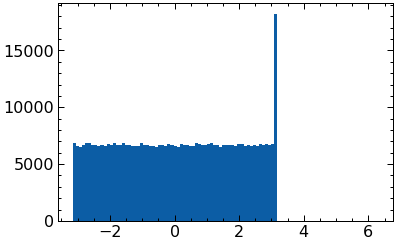

In [50]:
plt.hist(r.Ang_e[0], bins=100)
plt.show()

In [31]:
np.mean(a[15:-15]*1e11)

0.45542209582611287

Check compton energy transfer is correct

In [16]:
E, alpha, T, theta = smp.symbols(r'E \alpha T \theta', real=True, positive=True)
T_expr = E*alpha*(1-smp.cos(theta))/(1+alpha*(1-smp.cos(theta)))
theta_expr = smp.solve(T-T_expr, theta)[1]
dsdo_expr = smp.Rational(1,2)*(1+smp.cos(theta)**2)/(1+alpha*(1-smp.cos(theta)))**2 * \
            ( 1 + alpha**2 * (1-smp.cos(theta))**2 / ((1+smp.cos(theta)**2)*(1+alpha*(1-smp.cos(theta)))))
dsdT = 2*smp.pi*smp.sin(theta) * dsdo_expr / smp.diff(T_expr, theta)
dsdT = dsdT.subs(theta, theta_expr).simplify()
Tmin = 0 
Tmax = 2*E*alpha/(1+2*alpha)
sigma_check = smp.integrate(dsdT, (T, Tmin, Tmax)).expand().simplify().simplify()
pdf = dsdT / sigma_check
avgT = smp.integrate(pdf*(T/E), (T, Tmin, Tmax)).simplify().simplify()
avgT_f = smp.lambdify(alpha, avgT)
energy_arr = np.linspace(0.01, 6, 1000)
avgT_arr = avgT_f(energy_arr/0.511)

In [17]:
pdf_theta_f = smp.lambdify([theta, alpha], 2*smp.pi*smp.sin(theta) *dsdo_expr/sigma_check)

In [18]:
ratios, bins = np.histogram(r.comptonenergies, Ebins, weights=r.comptonratios)
total, bins = np.histogram(r.comptonenergies, Ebins)
T = ratios/total
Ep = bins[:-1] + np.diff(bins)/2

/Users/lukepolson/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


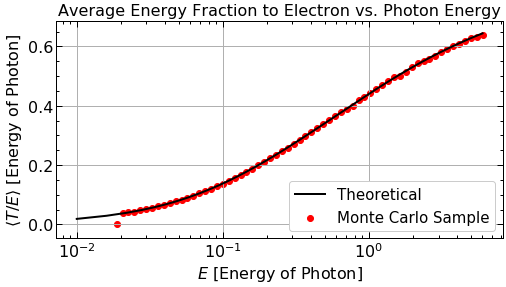

In [19]:
plt.figure(figsize=(8,4))
plt.scatter(Ep, T, color='r', label='Monte Carlo Sample')
plt.plot(energy_arr, avgT_arr, color='k', label='Theoretical')
plt.title('Average Energy Fraction to Electron vs. Photon Energy')
plt.xlabel('$E$ [Energy of Photon]')
plt.ylabel(r'$\left<T/E\right>$ [Energy of Photon]')
plt.grid()
plt.legend(fontsize=15, facecolor='white', framealpha=1, frameon=True, loc='lower right')
plt.semilogx()
plt.show()

In [20]:
r.iterate()

True

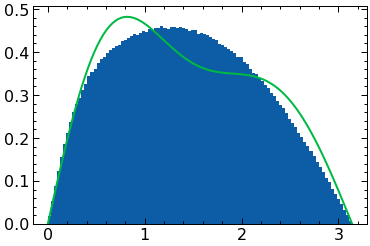

In [21]:
thetas = np.linspace(0, np.pi, 100)
ppddff = pdf_theta_f(thetas, 0.1/0.511)
plt.hist(r.comptonthetas, bins=100, density=True)
plt.plot(thetas, ppddff)
plt.show()